In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[2].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:05<00:00,  3.55it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:22<00:00,  2.96it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 12/2000 [00:03<04:20,  7.62it/s]

Epoch 10/2000, Loss: 0.6723
Test Accuracy at Epoch 10: 59.21%
Test F1-score at Epoch 10: 0.5845
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.60      0.60      0.60       194
non_infringement       0.58      0.59      0.58       186

        accuracy                           0.59       380
       macro avg       0.59      0.59      0.59       380
    weighted avg       0.59      0.59      0.59       380

New best model saved with F1-score 0.5845 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.60      0.60      0.60       194
non_infringement       0.58      0.59      0.58       186

        accuracy                           0.59       380
       macro avg       0.59      0.59      0.59       380
    weighted avg       0.59      0.59      0.59       380



Training Epochs:   1%|          | 20/2000 [00:06<14:59,  2.20it/s]

Epoch 20/2000, Loss: 0.6277
Test Accuracy at Epoch 20: 59.21%
Test F1-score at Epoch 20: 0.5910
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.60      0.58      0.59       194
non_infringement       0.58      0.60      0.59       186

        accuracy                           0.59       380
       macro avg       0.59      0.59      0.59       380
    weighted avg       0.59      0.59      0.59       380

New best model saved with F1-score 0.5910 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.60      0.58      0.59       194
non_infringement       0.58      0.60      0.59       186

        accuracy                           0.59       380
       macro avg       0.59      0.59      0.59       380
    weighted avg       0.59      0.59      0.59       380



Training Epochs:   2%|▏         | 30/2000 [00:11<18:53,  1.74it/s]

Epoch 30/2000, Loss: 0.5463
Test Accuracy at Epoch 30: 68.68%
Test F1-score at Epoch 30: 0.7018
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.62      0.67       194
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

New best model saved with F1-score 0.7018 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.62      0.67       194
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:   2%|▏         | 40/2000 [00:16<15:23,  2.12it/s]

Epoch 40/2000, Loss: 0.4705
Test Accuracy at Epoch 40: 69.47%
Test F1-score at Epoch 40: 0.7277
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.78      0.56      0.65       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380

New best model saved with F1-score 0.7277 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.78      0.56      0.65       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   2%|▎         | 50/2000 [00:21<18:37,  1.74it/s]

Epoch 50/2000, Loss: 0.4200
Test Accuracy at Epoch 50: 69.47%
Test F1-score at Epoch 50: 0.7277
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.78      0.56      0.65       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   3%|▎         | 61/2000 [00:24<05:27,  5.92it/s]

Epoch 60/2000, Loss: 0.3897
Test Accuracy at Epoch 60: 70.53%
Test F1-score at Epoch 60: 0.7214
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:   4%|▎         | 73/2000 [00:28<06:02,  5.32it/s]

Epoch 70/2000, Loss: 0.3704
Test Accuracy at Epoch 70: 70.26%
Test F1-score at Epoch 70: 0.7290
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380

New best model saved with F1-score 0.7290 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:   4%|▍         | 80/2000 [00:29<04:27,  7.17it/s]

Epoch 80/2000, Loss: 0.3593
Test Accuracy at Epoch 80: 73.16%
Test F1-score at Epoch 80: 0.7617
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380

New best model saved with F1-score 0.7617 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:   5%|▍         | 93/2000 [00:30<02:29, 12.73it/s]

Epoch 90/2000, Loss: 0.3502
Test Accuracy at Epoch 90: 73.16%
Test F1-score at Epoch 90: 0.7560
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.85      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.75      0.73      0.73       380



Training Epochs:   5%|▌         | 103/2000 [00:30<01:39, 19.05it/s]

Epoch 100/2000, Loss: 0.3440
Test Accuracy at Epoch 100: 74.21%
Test F1-score at Epoch 100: 0.7633
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

New best model saved with F1-score 0.7633 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:   6%|▌         | 113/2000 [00:31<01:20, 23.49it/s]

Epoch 110/2000, Loss: 0.3385
Test Accuracy at Epoch 110: 74.21%
Test F1-score at Epoch 110: 0.7633
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:   6%|▌         | 122/2000 [00:31<01:21, 23.18it/s]

Epoch 120/2000, Loss: 0.3344
Test Accuracy at Epoch 120: 75.26%
Test F1-score at Epoch 120: 0.7696
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with F1-score 0.7696 at epoch 120
Best Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   7%|▋         | 133/2000 [00:31<01:10, 26.32it/s]

Epoch 130/2000, Loss: 0.3308
Test Accuracy at Epoch 130: 75.00%
Test F1-score at Epoch 130: 0.7677
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       194
non_infringement       0.70      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   7%|▋         | 143/2000 [00:32<01:08, 27.20it/s]

Epoch 140/2000, Loss: 0.3251
Test Accuracy at Epoch 140: 75.00%
Test F1-score at Epoch 140: 0.7722
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.64      0.72       194
non_infringement       0.70      0.87      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

New best model saved with F1-score 0.7722 at epoch 140
Best Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.64      0.72       194
non_infringement       0.70      0.87      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:   8%|▊         | 153/2000 [00:32<01:18, 23.54it/s]

Epoch 150/2000, Loss: 0.3199
Test Accuracy at Epoch 150: 75.53%
Test F1-score at Epoch 150: 0.7759
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380

New best model saved with F1-score 0.7759 at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:   8%|▊         | 160/2000 [00:34<03:31,  8.70it/s]

Epoch 160/2000, Loss: 0.3136
Test Accuracy at Epoch 160: 76.58%
Test F1-score at Epoch 160: 0.7824
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.83      0.68      0.75       194
non_infringement       0.72      0.86      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

New best model saved with F1-score 0.7824 at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.83      0.68      0.75       194
non_infringement       0.72      0.86      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:   9%|▊         | 174/2000 [00:35<03:46,  8.07it/s]

Epoch 170/2000, Loss: 0.3082
Test Accuracy at Epoch 170: 76.58%
Test F1-score at Epoch 170: 0.7886
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.79      0.77      0.76       380

New best model saved with F1-score 0.7886 at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.79      0.77      0.76       380



Training Epochs:   9%|▉         | 184/2000 [00:36<02:02, 14.85it/s]

Epoch 180/2000, Loss: 0.3031
Test Accuracy at Epoch 180: 75.79%
Test F1-score at Epoch 180: 0.7723
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.81      0.68      0.74       194
non_infringement       0.72      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  10%|▉         | 193/2000 [00:36<01:37, 18.45it/s]

Epoch 190/2000, Loss: 0.2938
Test Accuracy at Epoch 190: 77.11%
Test F1-score at Epoch 190: 0.7914
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380

New best model saved with F1-score 0.7914 at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  10%|█         | 200/2000 [00:36<01:29, 20.16it/s]

Epoch 200/2000, Loss: 0.2856
Test Accuracy at Epoch 200: 76.84%
Test F1-score at Epoch 200: 0.7854
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.84      0.68      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  11%|█         | 213/2000 [00:37<01:36, 18.44it/s]

Epoch 210/2000, Loss: 0.2762
Test Accuracy at Epoch 210: 76.58%
Test F1-score at Epoch 210: 0.7835
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.84      0.67      0.74       194
non_infringement       0.72      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  11%|█         | 222/2000 [00:38<01:25, 20.85it/s]

Epoch 220/2000, Loss: 0.2659
Test Accuracy at Epoch 220: 77.11%
Test F1-score at Epoch 220: 0.7873
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.84      0.68      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  12%|█▏        | 231/2000 [00:38<01:20, 22.02it/s]

Epoch 230/2000, Loss: 0.2553
Test Accuracy at Epoch 230: 77.63%
Test F1-score at Epoch 230: 0.7932
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.85      0.68      0.76       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

New best model saved with F1-score 0.7932 at epoch 230
Best Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.85      0.68      0.76       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  12%|█▏        | 244/2000 [00:39<01:13, 24.00it/s]

Epoch 240/2000, Loss: 0.2481
Test Accuracy at Epoch 240: 75.00%
Test F1-score at Epoch 240: 0.7765
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  13%|█▎        | 256/2000 [00:39<01:03, 27.63it/s]

Epoch 250/2000, Loss: 0.2393
Test Accuracy at Epoch 250: 75.26%
Test F1-score at Epoch 250: 0.7773
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.69      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  13%|█▎        | 262/2000 [00:39<01:11, 24.35it/s]

Epoch 260/2000, Loss: 0.2265
Test Accuracy at Epoch 260: 79.21%
Test F1-score at Epoch 260: 0.8030
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.85      0.72      0.78       194
non_infringement       0.75      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1-score 0.8030 at epoch 260
Best Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.85      0.72      0.78       194
non_infringement       0.75      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  14%|█▎        | 274/2000 [00:40<01:13, 23.57it/s]

Epoch 270/2000, Loss: 0.2180
Test Accuracy at Epoch 270: 76.05%
Test F1-score at Epoch 270: 0.7818
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.73       194
non_infringement       0.71      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  14%|█▍        | 283/2000 [00:40<01:12, 23.71it/s]

Epoch 280/2000, Loss: 0.2094
Test Accuracy at Epoch 280: 75.53%
Test F1-score at Epoch 280: 0.7780
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  14%|█▍        | 290/2000 [00:41<02:04, 13.79it/s]

Epoch 290/2000, Loss: 0.2016
Test Accuracy at Epoch 290: 75.79%
Test F1-score at Epoch 290: 0.7799
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  15%|█▌        | 302/2000 [00:41<01:37, 17.43it/s]

Epoch 300/2000, Loss: 0.1939
Test Accuracy at Epoch 300: 75.53%
Test F1-score at Epoch 300: 0.7780
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  16%|█▌        | 311/2000 [00:42<01:36, 17.58it/s]

Epoch 310/2000, Loss: 0.1883
Test Accuracy at Epoch 310: 75.79%
Test F1-score at Epoch 310: 0.7810
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  16%|█▋        | 327/2000 [00:42<01:01, 27.28it/s]

Epoch 320/2000, Loss: 0.1860
Test Accuracy at Epoch 320: 75.79%
Test F1-score at Epoch 320: 0.7810
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  17%|█▋        | 331/2000 [00:43<00:58, 28.34it/s]

Epoch 330/2000, Loss: 0.1774
Test Accuracy at Epoch 330: 77.37%
Test F1-score at Epoch 330: 0.7902
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.85      0.68      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  17%|█▋        | 343/2000 [00:43<00:53, 30.79it/s]

Epoch 340/2000, Loss: 0.1729
Test Accuracy at Epoch 340: 75.53%
Test F1-score at Epoch 340: 0.7780
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  18%|█▊        | 356/2000 [00:43<00:49, 33.47it/s]

Epoch 350/2000, Loss: 0.1682
Test Accuracy at Epoch 350: 75.79%
Test F1-score at Epoch 350: 0.7810
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  18%|█▊        | 364/2000 [00:44<00:50, 32.24it/s]

Epoch 360/2000, Loss: 0.1643
Test Accuracy at Epoch 360: 75.53%
Test F1-score at Epoch 360: 0.7780
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  19%|█▊        | 372/2000 [00:44<00:52, 30.90it/s]

Epoch 370/2000, Loss: 0.1606
Test Accuracy at Epoch 370: 75.79%
Test F1-score at Epoch 370: 0.7810
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  19%|█▉        | 381/2000 [00:44<00:47, 34.30it/s]

Epoch 380/2000, Loss: 0.1573
Test Accuracy at Epoch 380: 75.53%
Test F1-score at Epoch 380: 0.7780
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  19%|█▉        | 389/2000 [00:44<00:54, 29.50it/s]

Epoch 390/2000, Loss: 0.1666
Test Accuracy at Epoch 390: 77.63%
Test F1-score at Epoch 390: 0.7932
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.85      0.68      0.76       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  20%|██        | 404/2000 [00:45<01:04, 24.59it/s]

Epoch 400/2000, Loss: 0.1529
Test Accuracy at Epoch 400: 75.79%
Test F1-score at Epoch 400: 0.7810
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  21%|██        | 411/2000 [00:45<00:58, 27.24it/s]

Epoch 410/2000, Loss: 0.1499
Test Accuracy at Epoch 410: 75.79%
Test F1-score at Epoch 410: 0.7810
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  21%|██        | 423/2000 [00:46<00:51, 30.70it/s]

Epoch 420/2000, Loss: 0.1479
Test Accuracy at Epoch 420: 75.79%
Test F1-score at Epoch 420: 0.7810
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  21%|██▏       | 427/2000 [00:46<00:56, 27.68it/s]

Epoch 430/2000, Loss: 0.1459
Test Accuracy at Epoch 430: 75.79%
Test F1-score at Epoch 430: 0.7810
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  22%|██▏       | 442/2000 [00:48<02:36,  9.93it/s]

Epoch 440/2000, Loss: 0.1443
Test Accuracy at Epoch 440: 75.53%
Test F1-score at Epoch 440: 0.7780
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  23%|██▎       | 453/2000 [00:48<01:30, 17.12it/s]

Epoch 450/2000, Loss: 0.1426
Test Accuracy at Epoch 450: 75.79%
Test F1-score at Epoch 450: 0.7810
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  23%|██▎       | 463/2000 [00:49<01:12, 21.17it/s]

Epoch 460/2000, Loss: 0.1415
Test Accuracy at Epoch 460: 75.79%
Test F1-score at Epoch 460: 0.7810
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  24%|██▎       | 470/2000 [00:49<01:01, 24.96it/s]

Epoch 470/2000, Loss: 0.1454
Test Accuracy at Epoch 470: 75.79%
Test F1-score at Epoch 470: 0.7810
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  24%|██▍       | 487/2000 [00:50<00:55, 27.28it/s]

Epoch 480/2000, Loss: 0.1416
Test Accuracy at Epoch 480: 75.79%
Test F1-score at Epoch 480: 0.7810
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  25%|██▍       | 495/2000 [00:50<00:51, 29.26it/s]

Epoch 490/2000, Loss: 0.1374
Test Accuracy at Epoch 490: 75.79%
Test F1-score at Epoch 490: 0.7810
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  25%|██▌       | 505/2000 [00:50<00:46, 32.20it/s]

Epoch 500/2000, Loss: 0.1369
Test Accuracy at Epoch 500: 75.53%
Test F1-score at Epoch 500: 0.7780
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  26%|██▌       | 515/2000 [00:51<00:40, 37.09it/s]

Epoch 510/2000, Loss: 0.1357
Test Accuracy at Epoch 510: 75.79%
Test F1-score at Epoch 510: 0.7810
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  26%|██▋       | 525/2000 [00:51<00:40, 36.80it/s]

Epoch 520/2000, Loss: 0.1345
Test Accuracy at Epoch 520: 75.79%
Test F1-score at Epoch 520: 0.7810
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  27%|██▋       | 534/2000 [00:51<00:45, 31.96it/s]

Epoch 530/2000, Loss: 0.1336
Test Accuracy at Epoch 530: 75.79%
Test F1-score at Epoch 530: 0.7810
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  27%|██▋       | 543/2000 [00:51<00:39, 36.92it/s]

Epoch 540/2000, Loss: 0.1470
Test Accuracy at Epoch 540: 75.00%
Test F1-score at Epoch 540: 0.7806
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.87      0.60      0.71       194
non_infringement       0.68      0.91      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.75       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:  28%|██▊       | 555/2000 [00:52<00:43, 33.42it/s]

Epoch 550/2000, Loss: 0.1409
Test Accuracy at Epoch 550: 74.47%
Test F1-score at Epoch 550: 0.7718
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.84      0.61      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  28%|██▊       | 563/2000 [00:52<00:48, 29.60it/s]

Epoch 560/2000, Loss: 0.1319
Test Accuracy at Epoch 560: 76.05%
Test F1-score at Epoch 560: 0.7818
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.73       194
non_infringement       0.71      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  29%|██▊       | 574/2000 [00:52<00:51, 27.96it/s]

Epoch 570/2000, Loss: 0.1313
Test Accuracy at Epoch 570: 75.79%
Test F1-score at Epoch 570: 0.7788
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.84      0.65      0.73       194
non_infringement       0.70      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  29%|██▉       | 582/2000 [00:53<00:51, 27.38it/s]

Epoch 580/2000, Loss: 0.1307
Test Accuracy at Epoch 580: 75.79%
Test F1-score at Epoch 580: 0.7810
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  30%|██▉       | 593/2000 [00:53<00:38, 36.41it/s]

Epoch 590/2000, Loss: 0.1298
Test Accuracy at Epoch 590: 75.79%
Test F1-score at Epoch 590: 0.7810
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  30%|███       | 601/2000 [00:53<00:52, 26.89it/s]

Epoch 600/2000, Loss: 0.1291
Test Accuracy at Epoch 600: 75.79%
Test F1-score at Epoch 600: 0.7810
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  31%|███       | 613/2000 [00:54<00:56, 24.68it/s]

Epoch 610/2000, Loss: 0.1285
Test Accuracy at Epoch 610: 75.79%
Test F1-score at Epoch 610: 0.7810
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  31%|███▏      | 625/2000 [00:54<00:57, 23.90it/s]

Epoch 620/2000, Loss: 0.1280
Test Accuracy at Epoch 620: 75.79%
Test F1-score at Epoch 620: 0.7810
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  32%|███▏      | 634/2000 [00:55<00:49, 27.52it/s]

Epoch 630/2000, Loss: 0.1274
Test Accuracy at Epoch 630: 75.79%
Test F1-score at Epoch 630: 0.7810
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  32%|███▏      | 642/2000 [00:55<00:42, 31.82it/s]

Epoch 640/2000, Loss: 0.1269
Test Accuracy at Epoch 640: 75.79%
Test F1-score at Epoch 640: 0.7810
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  33%|███▎      | 654/2000 [00:55<00:40, 33.32it/s]

Epoch 650/2000, Loss: 0.1264
Test Accuracy at Epoch 650: 75.79%
Test F1-score at Epoch 650: 0.7810
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  33%|███▎      | 667/2000 [00:56<00:37, 36.00it/s]

Epoch 660/2000, Loss: 0.1291
Test Accuracy at Epoch 660: 74.74%
Test F1-score at Epoch 660: 0.7757
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  34%|███▎      | 671/2000 [00:56<00:44, 29.95it/s]

Epoch 670/2000, Loss: 0.1343
Test Accuracy at Epoch 670: 79.74%
Test F1-score at Epoch 670: 0.8080
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.79       194
non_infringement       0.75      0.87      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380

New best model saved with F1-score 0.8080 at epoch 670
Best Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.79       194
non_infringement       0.75      0.87      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  34%|███▍      | 683/2000 [00:56<00:38, 34.25it/s]

Epoch 680/2000, Loss: 0.1315
Test Accuracy at Epoch 680: 79.74%
Test F1-score at Epoch 680: 0.8080
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.79       194
non_infringement       0.75      0.87      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  35%|███▍      | 696/2000 [00:57<00:35, 37.05it/s]

Epoch 690/2000, Loss: 0.1304
Test Accuracy at Epoch 690: 79.74%
Test F1-score at Epoch 690: 0.8080
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.79       194
non_infringement       0.75      0.87      0.81       186

        accuracy                           0.80       380
       macro avg       0.80      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  35%|███▌      | 704/2000 [00:57<00:38, 33.32it/s]

Epoch 700/2000, Loss: 0.1269
Test Accuracy at Epoch 700: 75.79%
Test F1-score at Epoch 700: 0.7810
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  36%|███▌      | 712/2000 [00:57<00:40, 31.48it/s]

Epoch 710/2000, Loss: 0.1243
Test Accuracy at Epoch 710: 75.79%
Test F1-score at Epoch 710: 0.7810
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  36%|███▋      | 725/2000 [00:58<00:40, 31.28it/s]

Epoch 720/2000, Loss: 0.1238
Test Accuracy at Epoch 720: 75.79%
Test F1-score at Epoch 720: 0.7810
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  37%|███▋      | 735/2000 [00:58<00:36, 35.10it/s]

Epoch 730/2000, Loss: 0.1235
Test Accuracy at Epoch 730: 75.79%
Test F1-score at Epoch 730: 0.7810
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  37%|███▋      | 744/2000 [00:58<00:36, 34.85it/s]

Epoch 740/2000, Loss: 0.1232
Test Accuracy at Epoch 740: 75.79%
Test F1-score at Epoch 740: 0.7810
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  38%|███▊      | 754/2000 [00:58<00:34, 36.13it/s]

Epoch 750/2000, Loss: 0.1228
Test Accuracy at Epoch 750: 75.53%
Test F1-score at Epoch 750: 0.7780
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:  38%|███▊      | 767/2000 [00:59<00:32, 37.99it/s]

Epoch 760/2000, Loss: 0.1225
Test Accuracy at Epoch 760: 75.26%
Test F1-score at Epoch 760: 0.7762
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  39%|███▉      | 776/2000 [00:59<00:32, 37.23it/s]

Epoch 770/2000, Loss: 0.1222
Test Accuracy at Epoch 770: 75.26%
Test F1-score at Epoch 770: 0.7762
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  39%|███▉      | 785/2000 [00:59<00:34, 34.90it/s]

Epoch 780/2000, Loss: 0.1219
Test Accuracy at Epoch 780: 75.26%
Test F1-score at Epoch 780: 0.7762
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  40%|███▉      | 796/2000 [00:59<00:29, 40.97it/s]

Epoch 790/2000, Loss: 0.1216
Test Accuracy at Epoch 790: 75.26%
Test F1-score at Epoch 790: 0.7762
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  40%|████      | 807/2000 [01:00<00:28, 42.14it/s]

Epoch 800/2000, Loss: 0.1220
Test Accuracy at Epoch 800: 75.26%
Test F1-score at Epoch 800: 0.7773
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.69      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 810/2000, Loss: 0.1215


Training Epochs:  41%|████      | 817/2000 [01:00<00:27, 42.50it/s]

Test Accuracy at Epoch 810: 75.79%
Test F1-score at Epoch 810: 0.7788
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.84      0.65      0.73       194
non_infringement       0.70      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  41%|████▏     | 828/2000 [01:00<00:25, 45.81it/s]

Epoch 820/2000, Loss: 0.1237
Test Accuracy at Epoch 820: 75.26%
Test F1-score at Epoch 820: 0.7762
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 830/2000, Loss: 0.1228


Training Epochs:  42%|████▏     | 833/2000 [01:00<00:25, 46.19it/s]

Test Accuracy at Epoch 830: 74.74%
Test F1-score at Epoch 830: 0.7725
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.84      0.62      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  42%|████▏     | 849/2000 [01:01<00:24, 47.30it/s]

Epoch 840/2000, Loss: 0.1203
Test Accuracy at Epoch 840: 75.26%
Test F1-score at Epoch 840: 0.7762
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 850/2000, Loss: 0.1202
Test Accuracy at Epoch 850: 75.26%
Test F1-score at Epoch 850: 0.7762
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  43%|████▎     | 866/2000 [01:01<00:24, 47.18it/s]

Epoch 860/2000, Loss: 0.1199
Test Accuracy at Epoch 860: 75.26%
Test F1-score at Epoch 860: 0.7762
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 870/2000, Loss: 0.1195
Test Accuracy at Epoch 870: 75.26%
Test F1-score at Epoch 870: 0.7762
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  44%|████▍     | 889/2000 [01:01<00:21, 51.65it/s]

Epoch 880/2000, Loss: 0.1193
Test Accuracy at Epoch 880: 75.26%
Test F1-score at Epoch 880: 0.7762
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 890/2000, Loss: 0.1197


Training Epochs:  45%|████▌     | 901/2000 [01:02<00:22, 49.79it/s]

Test Accuracy at Epoch 890: 75.53%
Test F1-score at Epoch 890: 0.7780
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380

Epoch 900/2000, Loss: 0.1235
Test Accuracy at Epoch 900: 77.63%
Test F1-score at Epoch 900: 0.7922
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  46%|████▌     | 914/2000 [01:02<00:22, 47.46it/s]

Epoch 910/2000, Loss: 0.1190
Test Accuracy at Epoch 910: 75.26%
Test F1-score at Epoch 910: 0.7762
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  46%|████▋     | 926/2000 [01:02<00:22, 46.93it/s]

Epoch 920/2000, Loss: 0.1191
Test Accuracy at Epoch 920: 75.26%
Test F1-score at Epoch 920: 0.7762
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  47%|████▋     | 938/2000 [01:02<00:22, 46.70it/s]

Epoch 930/2000, Loss: 0.1189
Test Accuracy at Epoch 930: 74.74%
Test F1-score at Epoch 930: 0.7725
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.84      0.62      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 940/2000, Loss: 0.1179
Test Accuracy at Epoch 940: 75.26%
Test F1-score at Epoch 940: 0.7762
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  48%|████▊     | 957/2000 [01:03<00:19, 52.57it/s]

Epoch 950/2000, Loss: 0.1176
Test Accuracy at Epoch 950: 75.26%
Test F1-score at Epoch 950: 0.7762
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 960/2000, Loss: 0.1176
Test Accuracy at Epoch 960: 75.00%
Test F1-score at Epoch 960: 0.7743
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  49%|████▉     | 976/2000 [01:03<00:19, 52.74it/s]

Epoch 970/2000, Loss: 0.1327
Test Accuracy at Epoch 970: 74.47%
Test F1-score at Epoch 970: 0.7749
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.86      0.60      0.71       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  49%|████▉     | 989/2000 [01:03<00:17, 58.71it/s]

Epoch 980/2000, Loss: 0.1245
Test Accuracy at Epoch 980: 74.74%
Test F1-score at Epoch 980: 0.7767
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.86      0.60      0.71       194
non_infringement       0.68      0.90      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 990/2000, Loss: 0.1218
Test Accuracy at Epoch 990: 74.74%
Test F1-score at Epoch 990: 0.7767
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.86      0.60      0.71       194
non_infringement       0.68      0.90      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  50%|█████     | 1007/2000 [01:04<00:19, 52.04it/s]

Epoch 1000/2000, Loss: 0.1260
Test Accuracy at Epoch 1000: 74.47%
Test F1-score at Epoch 1000: 0.7749
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.86      0.60      0.71       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380

Epoch 1010/2000, Loss: 0.1234
Test Accuracy at Epoch 1010: 74.47%
Test F1-score at Epoch 1010: 0.7707


Training Epochs:  51%|█████     | 1013/2000 [01:04<00:21, 46.00it/s]

Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.84      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  51%|█████▏    | 1027/2000 [01:04<00:17, 54.18it/s]

Epoch 1020/2000, Loss: 0.1167
Test Accuracy at Epoch 1020: 75.53%
Test F1-score at Epoch 1020: 0.7780
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380

Epoch 1030/2000, Loss: 0.1171
Test Accuracy at Epoch 1030: 75.26%
Test F1-score at Epoch 1030: 0.7762
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  52%|█████▏    | 1047/2000 [01:05<00:17, 55.42it/s]

Epoch 1040/2000, Loss: 0.1163
Test Accuracy at Epoch 1040: 75.26%
Test F1-score at Epoch 1040: 0.7762
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1050/2000, Loss: 0.1159
Test Accuracy at Epoch 1050: 75.00%
Test F1-score at Epoch 1050: 0.7743
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  53%|█████▎    | 1067/2000 [01:05<00:17, 54.46it/s]

Epoch 1060/2000, Loss: 0.1157
Test Accuracy at Epoch 1060: 75.00%
Test F1-score at Epoch 1060: 0.7743
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1070/2000, Loss: 0.1155
Test Accuracy at Epoch 1070: 75.00%
Test F1-score at Epoch 1070: 0.7743
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  54%|█████▍    | 1087/2000 [01:05<00:16, 54.45it/s]

Epoch 1080/2000, Loss: 0.1153
Test Accuracy at Epoch 1080: 75.00%
Test F1-score at Epoch 1080: 0.7743
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1090/2000, Loss: 0.1151
Test Accuracy at Epoch 1090: 75.00%
Test F1-score at Epoch 1090: 0.7743
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1107/2000 [01:06<00:16, 53.38it/s]

Epoch 1100/2000, Loss: 0.1150
Test Accuracy at Epoch 1100: 75.00%
Test F1-score at Epoch 1100: 0.7743
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1110/2000, Loss: 0.1148
Test Accuracy at Epoch 1110: 75.00%
Test F1-score at Epoch 1110: 0.7743
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  56%|█████▌    | 1119/2000 [01:07<00:50, 17.60it/s]

Epoch 1120/2000, Loss: 0.1146
Test Accuracy at Epoch 1120: 75.00%
Test F1-score at Epoch 1120: 0.7743
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1133/2000 [01:09<01:35,  9.07it/s]

Epoch 1130/2000, Loss: 0.1144
Test Accuracy at Epoch 1130: 75.00%
Test F1-score at Epoch 1130: 0.7743
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1142/2000 [01:10<01:12, 11.79it/s]

Epoch 1140/2000, Loss: 0.1143
Test Accuracy at Epoch 1140: 75.53%
Test F1-score at Epoch 1140: 0.7801
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  58%|█████▊    | 1152/2000 [01:11<00:56, 14.92it/s]

Epoch 1150/2000, Loss: 0.1141
Test Accuracy at Epoch 1150: 75.53%
Test F1-score at Epoch 1150: 0.7801
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  58%|█████▊    | 1163/2000 [01:11<00:53, 15.64it/s]

Epoch 1160/2000, Loss: 0.1139
Test Accuracy at Epoch 1160: 75.53%
Test F1-score at Epoch 1160: 0.7801
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  59%|█████▊    | 1172/2000 [01:12<00:49, 16.85it/s]

Epoch 1170/2000, Loss: 0.1139
Test Accuracy at Epoch 1170: 75.00%
Test F1-score at Epoch 1170: 0.7765
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  59%|█████▉    | 1181/2000 [01:12<00:58, 14.01it/s]

Epoch 1180/2000, Loss: 0.1264
Test Accuracy at Epoch 1180: 73.95%
Test F1-score at Epoch 1180: 0.7714
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.86      0.59      0.70       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380



Training Epochs:  60%|█████▉    | 1192/2000 [01:13<00:52, 15.44it/s]

Epoch 1190/2000, Loss: 0.1195
Test Accuracy at Epoch 1190: 73.95%
Test F1-score at Epoch 1190: 0.7714
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.86      0.59      0.70       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380



Training Epochs:  60%|██████    | 1202/2000 [01:14<00:53, 14.98it/s]

Epoch 1200/2000, Loss: 0.1150
Test Accuracy at Epoch 1200: 74.21%
Test F1-score at Epoch 1200: 0.7731
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.86      0.59      0.70       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  61%|██████    | 1212/2000 [01:15<00:58, 13.43it/s]

Epoch 1210/2000, Loss: 0.1136
Test Accuracy at Epoch 1210: 74.74%
Test F1-score at Epoch 1210: 0.7767
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.86      0.60      0.71       194
non_infringement       0.68      0.90      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  61%|██████    | 1222/2000 [01:15<00:52, 14.87it/s]

Epoch 1220/2000, Loss: 0.1132
Test Accuracy at Epoch 1220: 75.00%
Test F1-score at Epoch 1220: 0.7765
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  62%|██████▏   | 1233/2000 [01:16<00:41, 18.37it/s]

Epoch 1230/2000, Loss: 0.1142
Test Accuracy at Epoch 1230: 75.26%
Test F1-score at Epoch 1230: 0.7783
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  62%|██████▏   | 1244/2000 [01:16<00:30, 24.43it/s]

Epoch 1240/2000, Loss: 0.1144
Test Accuracy at Epoch 1240: 75.00%
Test F1-score at Epoch 1240: 0.7765
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  63%|██████▎   | 1252/2000 [01:17<00:45, 16.56it/s]

Epoch 1250/2000, Loss: 0.1133
Test Accuracy at Epoch 1250: 74.74%
Test F1-score at Epoch 1250: 0.7746
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  63%|██████▎   | 1261/2000 [01:17<00:37, 19.74it/s]

Epoch 1260/2000, Loss: 0.1127
Test Accuracy at Epoch 1260: 75.00%
Test F1-score at Epoch 1260: 0.7765
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  64%|██████▎   | 1274/2000 [01:18<00:32, 22.03it/s]

Epoch 1270/2000, Loss: 0.1126
Test Accuracy at Epoch 1270: 75.00%
Test F1-score at Epoch 1270: 0.7765
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  64%|██████▍   | 1280/2000 [01:18<00:33, 21.18it/s]

Epoch 1280/2000, Loss: 0.1123
Test Accuracy at Epoch 1280: 75.00%
Test F1-score at Epoch 1280: 0.7765
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  65%|██████▍   | 1293/2000 [01:19<00:46, 15.35it/s]

Epoch 1290/2000, Loss: 0.1120
Test Accuracy at Epoch 1290: 75.00%
Test F1-score at Epoch 1290: 0.7765
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  65%|██████▌   | 1302/2000 [01:20<00:52, 13.22it/s]

Epoch 1300/2000, Loss: 0.1118
Test Accuracy at Epoch 1300: 75.00%
Test F1-score at Epoch 1300: 0.7765
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  66%|██████▌   | 1312/2000 [01:20<00:33, 20.43it/s]

Epoch 1310/2000, Loss: 0.1117
Test Accuracy at Epoch 1310: 75.00%
Test F1-score at Epoch 1310: 0.7765
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  66%|██████▌   | 1322/2000 [01:21<00:28, 23.44it/s]

Epoch 1320/2000, Loss: 0.1115
Test Accuracy at Epoch 1320: 75.00%
Test F1-score at Epoch 1320: 0.7765
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  67%|██████▋   | 1334/2000 [01:21<00:30, 22.09it/s]

Epoch 1330/2000, Loss: 0.1114
Test Accuracy at Epoch 1330: 75.00%
Test F1-score at Epoch 1330: 0.7765
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  67%|██████▋   | 1344/2000 [01:21<00:23, 27.62it/s]

Epoch 1340/2000, Loss: 0.1112
Test Accuracy at Epoch 1340: 75.00%
Test F1-score at Epoch 1340: 0.7765
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  68%|██████▊   | 1355/2000 [01:22<00:21, 29.70it/s]

Epoch 1350/2000, Loss: 0.1111
Test Accuracy at Epoch 1350: 75.00%
Test F1-score at Epoch 1350: 0.7765
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  68%|██████▊   | 1362/2000 [01:22<00:23, 27.39it/s]

Epoch 1360/2000, Loss: 0.1109
Test Accuracy at Epoch 1360: 75.00%
Test F1-score at Epoch 1360: 0.7765
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  69%|██████▊   | 1372/2000 [01:23<00:29, 21.48it/s]

Epoch 1370/2000, Loss: 0.1108
Test Accuracy at Epoch 1370: 75.00%
Test F1-score at Epoch 1370: 0.7765
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  69%|██████▉   | 1381/2000 [01:23<00:34, 17.74it/s]

Epoch 1380/2000, Loss: 0.1111
Test Accuracy at Epoch 1380: 73.95%
Test F1-score at Epoch 1380: 0.7692
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  70%|██████▉   | 1391/2000 [01:24<00:56, 10.74it/s]

Epoch 1390/2000, Loss: 0.1164
Test Accuracy at Epoch 1390: 73.68%
Test F1-score at Epoch 1390: 0.7674
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  70%|███████   | 1400/2000 [01:25<00:40, 14.84it/s]

Epoch 1400/2000, Loss: 0.1105
Test Accuracy at Epoch 1400: 73.95%
Test F1-score at Epoch 1400: 0.7692
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  71%|███████   | 1411/2000 [01:26<00:39, 14.93it/s]

Epoch 1410/2000, Loss: 0.1105
Test Accuracy at Epoch 1410: 79.47%
Test F1-score at Epoch 1410: 0.8088
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380

New best model saved with F1-score 0.8088 at epoch 1410
Best Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  71%|███████   | 1419/2000 [01:26<00:32, 17.66it/s]

Epoch 1420/2000, Loss: 0.1101
Test Accuracy at Epoch 1420: 74.74%
Test F1-score at Epoch 1420: 0.7746
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  72%|███████▏  | 1433/2000 [01:27<00:26, 21.15it/s]

Epoch 1430/2000, Loss: 0.1102
Test Accuracy at Epoch 1430: 73.95%
Test F1-score at Epoch 1430: 0.7692
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  72%|███████▏  | 1440/2000 [01:27<00:33, 16.51it/s]

Epoch 1440/2000, Loss: 0.1098
Test Accuracy at Epoch 1440: 75.00%
Test F1-score at Epoch 1440: 0.7765
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  72%|███████▎  | 1450/2000 [01:33<04:18,  2.13it/s]

Epoch 1450/2000, Loss: 0.1105
Test Accuracy at Epoch 1450: 79.47%
Test F1-score at Epoch 1450: 0.8088
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.87      0.71      0.78       194
non_infringement       0.74      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  73%|███████▎  | 1460/2000 [01:37<02:46,  3.24it/s]

Epoch 1460/2000, Loss: 0.1123
Test Accuracy at Epoch 1460: 81.58%
Test F1-score at Epoch 1460: 0.8250
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.89      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380

New best model saved with F1-score 0.8250 at epoch 1460
Best Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.89      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  74%|███████▎  | 1470/2000 [01:39<02:57,  2.98it/s]

Epoch 1470/2000, Loss: 0.1107
Test Accuracy at Epoch 1470: 73.68%
Test F1-score at Epoch 1470: 0.7674
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  74%|███████▍  | 1479/2000 [01:44<04:37,  1.88it/s]

Epoch 1480/2000, Loss: 0.1098
Test Accuracy at Epoch 1480: 73.95%
Test F1-score at Epoch 1480: 0.7692


Training Epochs:  74%|███████▍  | 1480/2000 [01:45<05:15,  1.65it/s]

Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  74%|███████▍  | 1490/2000 [01:48<02:56,  2.88it/s]

Epoch 1490/2000, Loss: 0.1110
Test Accuracy at Epoch 1490: 81.58%
Test F1-score at Epoch 1490: 0.8250
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.89      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  75%|███████▌  | 1501/2000 [01:52<01:47,  4.63it/s]

Epoch 1500/2000, Loss: 0.1091
Test Accuracy at Epoch 1500: 75.00%
Test F1-score at Epoch 1500: 0.7765
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  76%|███████▌  | 1511/2000 [01:53<00:42, 11.55it/s]

Epoch 1510/2000, Loss: 0.1102
Test Accuracy at Epoch 1510: 73.68%
Test F1-score at Epoch 1510: 0.7674
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  76%|███████▌  | 1520/2000 [01:57<04:01,  1.99it/s]

Epoch 1520/2000, Loss: 0.1095
Test Accuracy at Epoch 1520: 73.95%
Test F1-score at Epoch 1520: 0.7692
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  76%|███████▋  | 1530/2000 [02:02<03:08,  2.49it/s]

Epoch 1530/2000, Loss: 0.1100
Test Accuracy at Epoch 1530: 81.32%
Test F1-score at Epoch 1530: 0.8229
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.87      0.74      0.80       194
non_infringement       0.77      0.89      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  77%|███████▋  | 1543/2000 [02:05<00:49,  9.15it/s]

Epoch 1540/2000, Loss: 0.1090
Test Accuracy at Epoch 1540: 78.16%
Test F1-score at Epoch 1540: 0.7990
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  78%|███████▊  | 1550/2000 [02:06<00:58,  7.72it/s]

Epoch 1550/2000, Loss: 0.1100
Test Accuracy at Epoch 1550: 72.89%
Test F1-score at Epoch 1550: 0.7621
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.72       380
    weighted avg       0.76      0.73      0.72       380



Training Epochs:  78%|███████▊  | 1560/2000 [02:10<02:34,  2.84it/s]

Epoch 1560/2000, Loss: 0.1085
Test Accuracy at Epoch 1560: 75.79%
Test F1-score at Epoch 1560: 0.7820
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  78%|███████▊  | 1570/2000 [02:15<03:26,  2.09it/s]

Epoch 1570/2000, Loss: 0.1095
Test Accuracy at Epoch 1570: 81.32%
Test F1-score at Epoch 1570: 0.8221
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  79%|███████▉  | 1580/2000 [02:21<04:08,  1.69it/s]

Epoch 1580/2000, Loss: 0.1086
Test Accuracy at Epoch 1580: 78.16%
Test F1-score at Epoch 1580: 0.7990
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  80%|███████▉  | 1590/2000 [02:26<03:53,  1.76it/s]

Epoch 1590/2000, Loss: 0.1089
Test Accuracy at Epoch 1590: 73.68%
Test F1-score at Epoch 1590: 0.7674
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  80%|████████  | 1600/2000 [02:32<03:32,  1.89it/s]

Epoch 1600/2000, Loss: 0.1088
Test Accuracy at Epoch 1600: 73.95%
Test F1-score at Epoch 1600: 0.7692
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  80%|████████  | 1610/2000 [02:37<03:40,  1.77it/s]

Epoch 1610/2000, Loss: 0.1087
Test Accuracy at Epoch 1610: 81.32%
Test F1-score at Epoch 1610: 0.8221
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.80       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.81       380
       macro avg       0.82      0.81      0.81       380
    weighted avg       0.82      0.81      0.81       380



Training Epochs:  81%|████████  | 1620/2000 [02:41<02:59,  2.12it/s]

Epoch 1620/2000, Loss: 0.1085
Test Accuracy at Epoch 1620: 79.47%
Test F1-score at Epoch 1620: 0.8079
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  82%|████████▏ | 1630/2000 [02:47<03:47,  1.62it/s]

Epoch 1630/2000, Loss: 0.1083
Test Accuracy at Epoch 1630: 72.89%
Test F1-score at Epoch 1630: 0.7621
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.72       380
    weighted avg       0.76      0.73      0.72       380



Training Epochs:  82%|████████▏ | 1640/2000 [02:53<03:16,  1.83it/s]

Epoch 1640/2000, Loss: 0.1085
Test Accuracy at Epoch 1640: 73.95%
Test F1-score at Epoch 1640: 0.7692
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  82%|████████▎ | 1650/2000 [02:58<03:12,  1.81it/s]

Epoch 1650/2000, Loss: 0.1077
Test Accuracy at Epoch 1650: 79.74%
Test F1-score at Epoch 1650: 0.8099
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.86      0.72      0.78       194
non_infringement       0.75      0.88      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  83%|████████▎ | 1660/2000 [03:03<03:00,  1.89it/s]

Epoch 1660/2000, Loss: 0.1091
Test Accuracy at Epoch 1660: 81.58%
Test F1-score at Epoch 1660: 0.8241
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  84%|████████▎ | 1670/2000 [03:06<02:17,  2.41it/s]

Epoch 1670/2000, Loss: 0.1073
Test Accuracy at Epoch 1670: 75.53%
Test F1-score at Epoch 1670: 0.7801
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  84%|████████▍ | 1680/2000 [03:11<02:45,  1.94it/s]

Epoch 1680/2000, Loss: 0.1090
Test Accuracy at Epoch 1680: 72.89%
Test F1-score at Epoch 1680: 0.7621
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.72       380
    weighted avg       0.76      0.73      0.72       380



Training Epochs:  84%|████████▍ | 1690/2000 [03:16<02:41,  1.92it/s]

Epoch 1690/2000, Loss: 0.1069
Test Accuracy at Epoch 1690: 78.42%
Test F1-score at Epoch 1690: 0.8000
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  85%|████████▌ | 1700/2000 [03:22<03:01,  1.65it/s]

Epoch 1700/2000, Loss: 0.1091
Test Accuracy at Epoch 1700: 81.84%
Test F1-score at Epoch 1700: 0.8262
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380

New best model saved with F1-score 0.8262 at epoch 1700
Best Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  86%|████████▌ | 1710/2000 [03:27<02:33,  1.89it/s]

Epoch 1710/2000, Loss: 0.1065
Test Accuracy at Epoch 1710: 75.79%
Test F1-score at Epoch 1710: 0.7810
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.85      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  86%|████████▌ | 1720/2000 [03:31<02:06,  2.22it/s]

Epoch 1720/2000, Loss: 0.1089
Test Accuracy at Epoch 1720: 72.89%
Test F1-score at Epoch 1720: 0.7621
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.72       380
    weighted avg       0.76      0.73      0.72       380



Training Epochs:  86%|████████▋ | 1730/2000 [03:36<02:26,  1.84it/s]

Epoch 1730/2000, Loss: 0.1062
Test Accuracy at Epoch 1730: 77.89%
Test F1-score at Epoch 1730: 0.7961
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  87%|████████▋ | 1740/2000 [03:41<02:23,  1.81it/s]

Epoch 1740/2000, Loss: 0.1086
Test Accuracy at Epoch 1740: 81.84%
Test F1-score at Epoch 1740: 0.8262
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  88%|████████▊ | 1750/2000 [03:45<01:01,  4.06it/s]

Epoch 1750/2000, Loss: 0.1059
Test Accuracy at Epoch 1750: 77.89%
Test F1-score at Epoch 1750: 0.7961
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  88%|████████▊ | 1759/2000 [03:45<00:22, 10.69it/s]

Epoch 1760/2000, Loss: 0.1079
Test Accuracy at Epoch 1760: 74.47%
Test F1-score at Epoch 1760: 0.7728
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  88%|████████▊ | 1770/2000 [03:46<00:18, 12.73it/s]

Epoch 1770/2000, Loss: 0.1058
Test Accuracy at Epoch 1770: 77.89%
Test F1-score at Epoch 1770: 0.7961
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  89%|████████▉ | 1779/2000 [03:49<00:47,  4.62it/s]

Epoch 1780/2000, Loss: 0.1073
Test Accuracy at Epoch 1780: 81.84%
Test F1-score at Epoch 1780: 0.8262
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  90%|████████▉ | 1794/2000 [03:50<00:22,  9.25it/s]

Epoch 1790/2000, Loss: 0.1060
Test Accuracy at Epoch 1790: 77.89%
Test F1-score at Epoch 1790: 0.7961
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  90%|█████████ | 1808/2000 [03:51<00:08, 21.41it/s]

Epoch 1800/2000, Loss: 0.1065
Test Accuracy at Epoch 1800: 74.74%
Test F1-score at Epoch 1800: 0.7736
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  91%|█████████ | 1812/2000 [03:51<00:12, 15.11it/s]

Epoch 1810/2000, Loss: 0.1065
Test Accuracy at Epoch 1810: 75.00%
Test F1-score at Epoch 1810: 0.7754
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  91%|█████████ | 1819/2000 [03:52<00:11, 15.14it/s]

Epoch 1820/2000, Loss: 0.1059
Test Accuracy at Epoch 1820: 78.42%
Test F1-score at Epoch 1820: 0.8000
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  92%|█████████▏| 1833/2000 [03:53<00:11, 14.22it/s]

Epoch 1830/2000, Loss: 0.1071
Test Accuracy at Epoch 1830: 81.58%
Test F1-score at Epoch 1830: 0.8241
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.87      0.75      0.81       194
non_infringement       0.77      0.88      0.82       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  92%|█████████▏| 1838/2000 [03:53<00:08, 18.80it/s]

Epoch 1840/2000, Loss: 0.1054
Test Accuracy at Epoch 1840: 75.26%
Test F1-score at Epoch 1840: 0.7773
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.69      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  92%|█████████▎| 1850/2000 [03:59<01:02,  2.40it/s]

Epoch 1850/2000, Loss: 0.1075
Test Accuracy at Epoch 1850: 74.74%
Test F1-score at Epoch 1850: 0.7736
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  93%|█████████▎| 1860/2000 [04:05<01:24,  1.66it/s]

Epoch 1860/2000, Loss: 0.1049
Test Accuracy at Epoch 1860: 77.89%
Test F1-score at Epoch 1860: 0.7961
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  94%|█████████▎| 1870/2000 [04:11<01:17,  1.67it/s]

Epoch 1870/2000, Loss: 0.1075
Test Accuracy at Epoch 1870: 81.84%
Test F1-score at Epoch 1870: 0.8262
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  94%|█████████▍| 1880/2000 [04:16<01:11,  1.68it/s]

Epoch 1880/2000, Loss: 0.1046
Test Accuracy at Epoch 1880: 77.37%
Test F1-score at Epoch 1880: 0.7923
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  94%|█████████▍| 1890/2000 [04:22<01:03,  1.74it/s]

Epoch 1890/2000, Loss: 0.1068
Test Accuracy at Epoch 1890: 74.74%
Test F1-score at Epoch 1890: 0.7736
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  95%|█████████▌| 1901/2000 [04:26<00:24,  4.11it/s]

Epoch 1900/2000, Loss: 0.1046
Test Accuracy at Epoch 1900: 77.37%
Test F1-score at Epoch 1900: 0.7923
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  96%|█████████▌| 1910/2000 [04:30<00:48,  1.86it/s]

Epoch 1910/2000, Loss: 0.1060
Test Accuracy at Epoch 1910: 81.84%
Test F1-score at Epoch 1910: 0.8262
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  96%|█████████▌| 1920/2000 [04:35<00:46,  1.71it/s]

Epoch 1920/2000, Loss: 0.1049
Test Accuracy at Epoch 1920: 77.89%
Test F1-score at Epoch 1920: 0.7961
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  96%|█████████▋| 1930/2000 [04:41<00:41,  1.68it/s]

Epoch 1930/2000, Loss: 0.1052
Test Accuracy at Epoch 1930: 74.74%
Test F1-score at Epoch 1930: 0.7736
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  97%|█████████▋| 1940/2000 [04:46<00:33,  1.82it/s]

Epoch 1940/2000, Loss: 0.1056
Test Accuracy at Epoch 1940: 75.00%
Test F1-score at Epoch 1940: 0.7754
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.88      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  98%|█████████▊| 1950/2000 [04:51<00:26,  1.87it/s]

Epoch 1950/2000, Loss: 0.1045
Test Accuracy at Epoch 1950: 77.89%
Test F1-score at Epoch 1950: 0.7961
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  98%|█████████▊| 1959/2000 [04:54<00:08,  4.72it/s]

Epoch 1960/2000, Loss: 0.1064
Test Accuracy at Epoch 1960: 81.84%
Test F1-score at Epoch 1960: 0.8262
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.82      0.82      0.82       380
    weighted avg       0.82      0.82      0.82       380



Training Epochs:  99%|█████████▊| 1971/2000 [04:56<00:03,  8.85it/s]

Epoch 1970/2000, Loss: 0.1040
Test Accuracy at Epoch 1970: 76.84%
Test F1-score at Epoch 1970: 0.7885
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.74       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  99%|█████████▉| 1983/2000 [04:56<00:01, 16.90it/s]

Epoch 1980/2000, Loss: 0.1064
Test Accuracy at Epoch 1980: 74.74%
Test F1-score at Epoch 1980: 0.7736
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs: 100%|█████████▉| 1992/2000 [04:57<00:00, 19.06it/s]

Epoch 1990/2000, Loss: 0.1037
Test Accuracy at Epoch 1990: 77.37%
Test F1-score at Epoch 1990: 0.7923
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs: 100%|██████████| 2000/2000 [04:57<00:00,  6.71it/s]
/tmp/ipykernel_327735/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_st

Epoch 2000/2000, Loss: 0.1059
Test Accuracy at Epoch 2000: 82.11%
Test F1-score at Epoch 2000: 0.8283
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380

New best model saved with F1-score 0.8283 at epoch 2000
Best Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



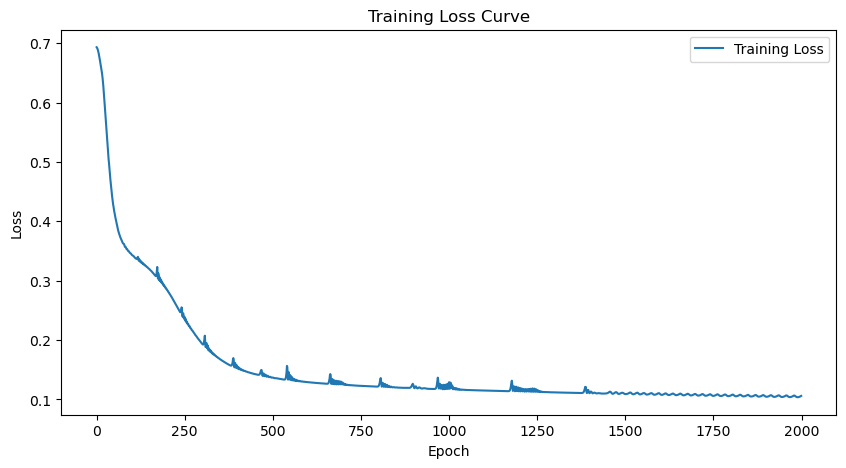

Final Model Accuracy: 82.11%
Final Model F1-score: 0.8283


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 82.11%
                  precision    recall  f1-score   support

    infringement       0.87      0.76      0.81       194
non_infringement       0.78      0.88      0.83       186

        accuracy                           0.82       380
       macro avg       0.83      0.82      0.82       380
    weighted avg       0.83      0.82      0.82       380



/tmp/ipykernel_327735/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
